# CME statistics

cme_statistics.py
https://github.com/cmoestl/heliocats
analyses ICMECAT data for paper on CME statistics Moestl et al. 2020

Author: C. Moestl, IWF Graz, Austria
twitter @chrisoutofspace, https://github.com/cmoestl
last update March 2020

for installation of a conda environment to run this code, see instructions in README.md.

Conda dependencies are listed under environment.yml, and pip in requirements.txt.

structure of this code:

0. Settings and load data

1. ICME arrival frequencies

2. ICME duration 

3. Magnetic field 

4. Times the planets spend inside ICMEs total, yearly and per solar cycle phase


plots are saved in results/plots_stats/ as png and pdf

analysis results files are written to data/

convert to script with 

    jupyter nbconvert --to script cme_statistics.ipynb


In [3]:
from scipy import stats
import scipy.io
from matplotlib import cm
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import astropy.constants as const
from sunpy.time import parse_time
import sunpy.time
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib

#where the 6 in situ data files are located is read from input.py
#as data_path=....
from config import data_path


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')

#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings


from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging


#Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb
os.system('jupyter nbconvert --to script cme_statistics.ipynb')    


0

## 0. Settings and load data



In [32]:

plt.close('all')

print('cme_statistics main program.')
print('ICME parameters at all 4 terrestrial planets.')
print('Christian Moestl et al., IWF Graz, Austria, last update March 2020')


#constants 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)


########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots_stats'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)

load_data=1

if load_data > 0:
  
    print('load data')

    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )

    filewin="wind_2007_2018_heeq_helcats.p" 
    [win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

    filevex='vex_2007_2014_sceq_removed.p'
    [vex,hvex]=pickle.load(open(data_path+filevex, 'rb' ) )

    filemes='messenger_2007_2015_sceq_removed.p'
    [mes,hmes]=pickle.load(open(data_path+filemes, 'rb' ) )
 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
             
    filesta='stereoa_2007_2019_sceq.p'
    [sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

    filepsp='psp_2018_2019_sceq.p'
    [psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) )  
    
    fileuly='ulysses_1990_2009_rtn.p'
    [uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) ) 


    # ADD BepiColombo  
        
    # ADD Solar Orbiter
    
    print('load all data done')

    
############# get positions from a 
# pre-made IDL sav file for older spacecraft positions
print()
print('get positions')
pos = hs.getcat('data/positions_2007_2023_HEEQ_6hours.sav')
pos_time= hs.decode_array(pos.time) 
pos_time_num=parse_time(pos_time).plot_date 
print('positions done')


########### load ICMECAT v2.0, made with icmecat.py/ipynb
file='icmecat/HELCATS_ICMECAT_v20_pandas.p'
print()
print('loaded ', file)
print()
print('Keys (parameters) in this pandas data frame are:')

[ic,h,p]=pickle.load(open(file, "rb" ) )  
print(ic.keys())
print()

#get indices of events for each spacecraft
wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    
ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]   
pspi=np.where(ic.sc_insitu == 'ParkerSolarProbe')[:][0]    
#get indices for Mercury after orbit insertion in March 2011
merci=np.where(np.logical_and(ic.sc_insitu =='MESSENGER', ic.icme_start_time > parse_time('2011-03-18').datetime))[0]


############### set limits of solar minimum, rising/declining phase and solar maximum

minstart=parse_time('2007-01-01').datetime
minend=parse_time('2009-12-31').datetime
minstart_num=parse_time('2007-01-01').plot_date
minend_num=parse_time('2009-12-31').plot_date

risestart=parse_time('2010-01-01').datetime
riseend=parse_time('2011-06-30').datetime
risestart_num=parse_time('2010-01-01').plot_date
riseend_num=parse_time('2011-06-30').plot_date

maxstart=parse_time('2011-07-01').datetime
maxend=parse_time('2014-12-31').datetime
maxstart_num=parse_time('2011-07-01').plot_date
maxend_num=parse_time('2014-12-31').plot_date

declstart=parse_time('2015-01-01').datetime
declend=parse_time('2017-12-31').datetime
declstart_num=parse_time('2015-01-01').plot_date
declend_num=parse_time('2017-12-31').plot_date


############### extract events by limits of solar min, 
############### rising, max -> too few events for MAVEN and Ulysses

#get all events for minimum
iall_min=np.where(np.logical_and(ic.icme_start_time > minstart,ic.icme_start_time < minend))[0]
iall_rise=np.where(np.logical_and(ic.icme_start_time > risestart,ic.icme_start_time < riseend))[0]
iall_max=np.where(np.logical_and(ic.icme_start_time > maxstart,ic.icme_start_time < maxend))[0]

wini_min=iall_min[np.where(ic.sc_insitu[iall_min]=='Wind')]
wini_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='Wind')]
wini_max=iall_max[np.where(ic.sc_insitu[iall_max]=='Wind')]

vexi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='VEX')]
vexi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='VEX')]
vexi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='VEX')]

mesi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='MESSENGER')]
mesi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='MESSENGER')]
mesi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='MESSENGER')]

stai_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-A')]
stai_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-A')]
stai_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-A')]

stbi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-B')]
stbi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-B')]
stbi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-B')]

# select the events at Mercury extra after orbit insertion, note that no events available for solar minimum
merci_min=iall_min[np.where(np.logical_and(ic.sc_insitu[iall_min] =='MESSENGER',ic.icme_start_time[iall_min] > parse_time('2011-03-18').datetime))]
merci_rise=iall_rise[np.where(np.logical_and(ic.sc_insitu[iall_rise] =='MESSENGER',ic.icme_start_time[iall_rise] > parse_time('2011-03-18').datetime))]
merci_max=iall_max[np.where(np.logical_and(ic.sc_insitu[iall_max] =='MESSENGER',ic.icme_start_time[iall_max] > parse_time('2011-03-18').datetime))]

print('done')

cme_statistics main program.
ICME parameters at all 4 terrestrial planets.
Christian Moestl et al., IWF Graz, Austria, last update March 2020
load data
load all data done

get positions
positions done

loaded  icmecat/HELCATS_ICMECAT_v20_pandas.p

Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std

In [33]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_Wind_NASA_20070114_01,Wind,2007-01-14 11:31:00,2007-01-14 11:44:00,2007-01-15 07:45:00,0.9729,0.14,-4.43,20.23,14.6,...,5.0,2.1,15652.6,9616.6,310.4,1.2,1.1,0.1,0.2,0.0
1,ICME_Wind_NASA_20070115_01,Wind,2007-01-15 20:49:00,2007-01-15 20:49:00,2007-01-16 04:45:00,0.9731,0.15,-4.57,7.93,10.4,...,4.1,1.4,97358.1,37602.1,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_Wind_NASA_20070329_01,Wind,2007-03-29 15:04:00,2007-03-29 15:04:00,2007-03-30 00:03:00,0.9900,-0.02,-6.74,8.98,6.1,...,5.2,1.0,16707.4,8263.1,NaN,NaN,NaN,NaN,NaN,NaN
3,ICME_Wind_NASA_20070521_01,Wind,2007-05-21 22:40:00,2007-05-21 22:45:00,2007-05-22 13:25:00,1.0020,-0.23,-1.91,14.75,14.0,...,6.7,2.6,41975.6,17102.7,462.5,2.1,1.9,0.2,0.7,0.1
4,ICME_Wind_NASA_20070608_01,Wind,2007-06-08 05:45:00,2007-06-08 05:45:00,2007-06-09 05:15:00,1.0040,-0.13,0.19,23.50,9.8,...,7.3,1.9,53830.2,25294.9,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,ICME_MAVEN_MOESTL_20170119_01,MAVEN,2017-01-19 05:50:00,2017-01-19 15:00:00,2017-01-20 18:30:00,1.4262,-91.86,4.74,36.67,5.5,...,2.6,0.8,287437.6,242820.6,357.1,9.7,2.8,0.7,0.6,0.2
694,ICME_MAVEN_MOESTL_20170703_01,MAVEN,2017-07-03 22:20:00,2017-07-04 21:00:00,2017-07-06 04:40:00,1.6225,-168.71,-2.80,54.33,7.8,...,4.8,1.4,369548.7,456549.3,378.7,6.1,2.6,1.2,0.6,0.3
695,ICME_MAVEN_MOESTL_20170722_01,MAVEN,2017-07-22 14:30:00,2017-07-22 14:30:00,2017-07-24 11:50:00,1.6368,-177.51,-3.47,45.33,6.7,...,4.8,1.4,178292.6,220041.6,NaN,NaN,NaN,NaN,NaN,NaN
696,ICME_MAVEN_MOESTL_20170726_01,MAVEN,2017-07-26 04:30:00,2017-07-26 09:00:00,2017-07-27 12:10:00,1.6396,-179.41,-3.60,31.67,21.4,...,2.4,0.8,1167580.7,1128618.7,666.2,0.0,0.5,0.0,0.4,0.0


## 1. arrival frequencies in ICMECAT 

### 1a Data days available each year for each planet

In [48]:
#make bin for each year for yearly histograms
#define dates of January 1 from 2007 to 2017
years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,2018) ] 
yearly_start_times=parse_time(years_jan_1_str).plot_date
yearly_start_times_d=parse_time(years_jan_1_str).datetime


#same for July
years_jul_1_str=[str(i)+'-07-01' for i in np.arange(2007,2018) ] 
yearly_mid_times=parse_time(years_jul_1_str).plot_date
yearly_mid_times_d=parse_time(years_jul_1_str).datetime


#same for december
years_dec_31_str=[str(i)+'-12-31' for i in np.arange(2007,2018) ] 
yearly_end_times=parse_time(years_dec_31_str).plot_date
yearly_end_times_d=parse_time(years_dec_31_str).datetime



########### 2a Determine for SOLAR WIND ONLY MISSIONS STA, STB, Wind
########### all are available in 1 minute time resolution 

#define arrays and fill with nan
total_data_days_yearly_win=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_win.fill(np.nan)

total_data_days_yearly_sta=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_sta.fill(np.nan)

total_data_days_yearly_stb=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_stb.fill(np.nan)

total_data_days_yearly_mes=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_mes.fill(np.nan)

total_data_days_yearly_merc=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_merc.fill(np.nan)

total_data_days_yearly_vex=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_vex.fill(np.nan)

total_data_days_yearly_mav=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_mav.fill(np.nan)


#go through each year and search for available data
#time is available for all dates, so no NaNs in time
#all NaNs in Btotal variable

for i in range(np.size(yearly_mid_times)):

  #Wind index for this year  
  thisyear=np.where(np.logical_and((win.time > yearly_start_times_d[i]),(win.time < yearly_end_times_d[i])))
  #get np.size of available data for each year
  datas=np.size(np.where(np.isnan(win.bt[thisyear])==False))
  #wind is  in 1 minute resolution
  min_in_days=1/(60*24)
  #calculate available days from number of datapoints (each 1 minute) 
  #divided by number of minutes in 1 days
  #this should only be the case if data is available this year, otherwise set to NaN
  if datas >0: total_data_days_yearly_win[i]=datas*min_in_days

  #same for STEREO-A
  thisyear=np.where(np.logical_and((sta.time > yearly_start_times_d[i]),(sta.time < yearly_end_times_d[i])))
  datas=np.size(np.where(np.isnan(sta.bt[thisyear])==False))
  if datas >0: total_data_days_yearly_sta[i]=datas*min_in_days

  #same for STEREO-B
  thisyear=np.where(np.logical_and((stb.time > yearly_start_times_d[i]),(stb.time < yearly_end_times_d[i])))
  datas=np.size(np.where(np.isnan(stb.bt[thisyear])==False))
  if datas >0: total_data_days_yearly_stb[i]=datas*min_in_days

  #same for MESSENGER
  thisyear=np.where(np.logical_and((mes.time > yearly_start_times_d[i]),(mes.time < yearly_end_times_d[i])))
  datas=np.size(np.where(np.isnan(mes.bt[thisyear])==False))
  if datas >0: total_data_days_yearly_mes[i]=datas*min_in_days

  #same for Mercury alone
  #start with 2011
  if i == 4: 
   thisyear=np.where(np.logical_and((mes.time > parse_time('2011-03-18').datetime),(mes.time < yearly_end_times_d[i])))
   datas=np.size(np.where(np.isnan(mes.bt[thisyear])==False))
   if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
  #2012 onwards 
  if i > 4: 
   thisyear=np.where(np.logical_and((mes.time > yearly_start_times_d[i]),(mes.time < yearly_end_times_d[i])))
   datas=np.size(np.where(np.isnan(mes.bt[thisyear])==False))
   if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
      

  #same for VEX
  thisyear=np.where(np.logical_and((vex.time > yearly_start_times_d[i]),(vex.time < yearly_end_times_d[i])))
  datas=np.size(np.where(np.isnan(vex.bt[thisyear])==False))
  if datas >0: total_data_days_yearly_vex[i]=datas*min_in_days

  #for MAVEN different time resolution
  thisyear=np.where(np.logical_and((mav.time > yearly_start_times_d[i]),(mav.time < yearly_end_times_d[i])))
  datas=np.size(np.where(np.isnan(mav.bt[thisyear])==False))
  datas_ind=np.where(np.isnan(mav.bt[thisyear])==False)
  #sum all time intervals for existing data points, but avoid counting gaps where diff is > 1 orbit (0.25 days)
  alldiff=np.diff(parse_time(mav.time[datas_ind]).plot_date)
  smalldiff_ind=np.where(alldiff <0.25)  
  if datas >0: total_data_days_yearly_mav[i]=np.sum(alldiff[smalldiff_ind])

print('Data days each year:')

print()
print('Wind')
print(np.round(total_data_days_yearly_win,1))
print('STA')
print(np.round(total_data_days_yearly_sta,1))
print('STB')
print(np.round(total_data_days_yearly_stb,1))
print('MERCURY')
print(np.round(total_data_days_yearly_merc,1))
print('MES')
print(np.round(total_data_days_yearly_mes,1))
print('VEX')
print(np.round(total_data_days_yearly_vex,1))
print('MAV')
print(np.round(total_data_days_yearly_mav,1))

Data days each year:

Wind
[356.5 357.7 352.5 354.  353.5 355.8 355.7 329.5 351.2 359.6 360.8]
STA
[361.  361.9 361.1 356.  357.6 356.5 353.6 238.1 233.7 363.1 333.3]
STB
[361.3 364.1 361.2 345.1 351.  355.5 356.5 261.5   nan   nan   nan]
MERCURY
[  nan   nan   nan   nan 203.7 227.7 194.1 209.8  76.4   nan   nan]
MES
[138.1  87.9 267.  361.  278.7 227.7 194.1 209.8  76.4   nan   nan]
VEX
[307.3 295.9 302.7 287.1 286.5 299.6 288.1 240.7   nan   nan   nan]
MAV
[  nan   nan   nan   nan   nan   nan   nan  36.5 225.1 260.1 181.9]


### 1b plot ICME frequency

for solar min 2007-2009 average ICME per year rate:
8.269788191113014
for 2010 2011
19.748286030048412
for 2012 2013 2014
27.373344770100392


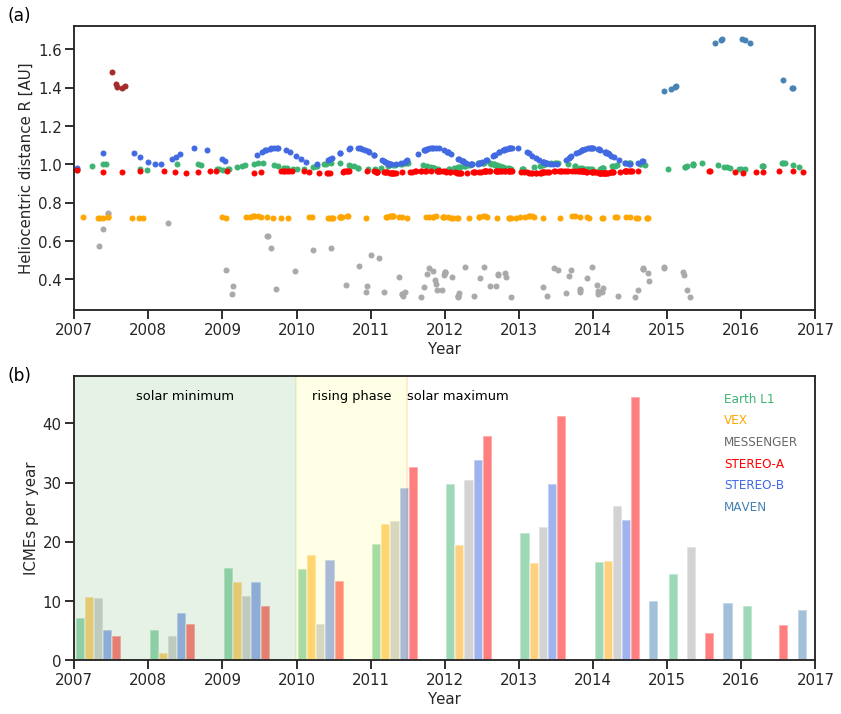

In [49]:
#define dates of January 1 from 2007 to 2017
years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,2019) ] 
yearly_bin_edges=parse_time(years_jan_1_str).plot_date

#bin width in days         
binweite=360/8

sns.set_context("talk")     
sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(4,figsize=(12,10	))

#Fig 1a
ax1 = plt.subplot(211) 
plt.plot_date(ic.icme_start_time[wini],ic.mo_sc_heliodistance[wini],fmt='o',color='mediumseagreen',markersize=5)
plt.plot_date(ic.icme_start_time[mesi],ic.mo_sc_heliodistance[mesi],fmt='o',color='darkgrey',markersize=5)
plt.plot_date(ic.icme_start_time[vexi],ic.mo_sc_heliodistance[vexi],fmt='o',color='orange',markersize=5)
plt.plot_date(ic.icme_start_time[stbi],ic.mo_sc_heliodistance[stbi],fmt='o',color='royalblue',markersize=5)
plt.plot_date(ic.icme_start_time[stai],ic.mo_sc_heliodistance[stai],fmt='o',color='red',markersize=5)
plt.plot_date(ic.icme_start_time[ulyi],ic.mo_sc_heliodistance[ulyi],fmt='o',color='brown',markersize=5)
plt.plot_date(ic.icme_start_time[mavi],ic.mo_sc_heliodistance[mavi],fmt='o',color='steelblue',markersize=5)

plt.ylabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.xlabel('Year',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 

plt.xlim(yearly_bin_edges[0],yearly_bin_edges[10])
ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)


# Fig 1b

(histwin, bin_edgeswin) = np.histogram(mdates.date2num(ic.icme_start_time[wini]), yearly_bin_edges)
(histvex, bin_edgesvex) = np.histogram(mdates.date2num(ic.icme_start_time[vexi]), yearly_bin_edges)
(histmes, bin_edgesmes) = np.histogram(mdates.date2num(ic.icme_start_time[mesi]), yearly_bin_edges)
(histstb, bin_edgesstb) = np.histogram(mdates.date2num(ic.icme_start_time[stbi]), yearly_bin_edges)
(histsta, bin_edgessta) = np.histogram(mdates.date2num(ic.icme_start_time[stai]), yearly_bin_edges)
(histmav, bin_edgesmav) = np.histogram(mdates.date2num(ic.icme_start_time[mavi]), yearly_bin_edges)

#normalize each dataset for data gaps

histwin=histwin/total_data_days_yearly_win*365
histvex=histvex/total_data_days_yearly_vex*365
histmes=histmes/total_data_days_yearly_mes*365
histsta=histsta/total_data_days_yearly_sta*365
histstb=histstb/total_data_days_yearly_stb*365
histmav=histmav/total_data_days_yearly_mav*365

binedges=bin_edgeswin
#pickle.dump([binedges,histwin,histvex,histmes,histsta,histstb,histmav], \
#             open( "data/icme_frequency.p", "wb" ), protocol=2 )
#[binedges,histwin,histvex,histmes,histsta,histstb,histmav]=pickle.load( open( "plots_stats/stats/icme_frequency.p", "rb" ) )

ax2 = plt.subplot(212) 

#binweite=45
ax2.bar(bin_edgeswin[:-1]+30,histwin, width=binweite,color='mediumseagreen', alpha=0.5)
ax2.bar(bin_edgesvex[:-1]+30+binweite,histvex, width=binweite,color='orange', alpha=0.5)
ax2.bar(bin_edgesmes[:-1]+30+ binweite*2,histmes, width=binweite,color='darkgrey', alpha=0.5)
ax2.bar(bin_edgesstb[:-1]+30+binweite*3,histstb, width=binweite,color='royalblue', alpha=0.5)
ax2.bar(bin_edgessta[:-1]+30+binweite*4,histsta, width=binweite,color='red', alpha=0.5)
#ax2.bar(bin_edgessta[:-1]+30+binweite*5,histuly, width=binweite,color='brown', alpha=0.5)
ax2.bar(bin_edgesmav[:-1]+30+binweite*6,histmav, width=binweite,color='steelblue', alpha=0.5)

plt.xlim(yearly_bin_edges[0],yearly_bin_edges[10])
ax2.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(myformat)
#sets planet / spacecraft labels
xoff=0.85 
yoff=0.45
fsize=12
plt.figtext(xoff,yoff,'Earth L1',color='mediumseagreen', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*1,'VEX',color='orange', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*2,'MESSENGER',color='dimgrey', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*3,'STEREO-A',color='red', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*4,'STEREO-B',color='royalblue', fontsize=fsize, ha='left')
#plt.figtext(xoff,yoff-0.03*5,'Ulysses',color='brown', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*5,'MAVEN',color='steelblue', fontsize=fsize, ha='left')
#panel labels
plt.figtext(0.02,0.98,'(a)',color='black', fontsize=fsize+5, ha='left')
plt.figtext(0.02,0.48,'(b)',color='black', fontsize=fsize+5, ha='left')
plt.ylim(0,48)
#limits solar min/rise/max
vlevel=44
fsize=13

plt.axvspan(minstart_num,minend_num, color='green', alpha=0.1)
plt.annotate('solar minimum',xy=(minstart_num+(minend_num-minstart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)

plt.axvspan(risestart_num,riseend_num, color='yellow', alpha=0.1)
plt.annotate('rising phase',xy=(risestart_num+(riseend_num-risestart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)

plt.axvspan(maxstart_num,maxstart_num, color='red', alpha=0.1)
plt.annotate('solar maximum',xy=(maxstart_num+(maxstart_num-maxstart_num)/2,vlevel),color='black', ha='left', fontsize=fsize)

fsize=15
plt.ylabel('ICMEs per year',fontsize=fsize)
plt.xlabel('Year',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
plt.tight_layout()


#++++++++++++++++++ Sunspot number in back with right axis

#sns.despine()

plt.savefig('results/plots_stats/ICME_frequency_paper.pdf', dpi=300)
plt.savefig('results/plots_stats/ICME_frequency_paper.png', dpi=300)


#calculate general parameters

print('for solar min 2007-2009 average ICME per year rate:')
mean07=np.mean([histwin[0],histvex[0],histsta[0],histstb[0],histmes[0]])
mean08=np.mean([histwin[1],histvex[1],histsta[1],histstb[1],histmes[1]])
mean09=np.mean([histwin[2],histvex[2],histsta[2],histstb[2],histmes[2]])
print(np.nanmean([mean07,mean08,mean09]))

print('for 2010 2011')
mean10=np.mean([histwin[3],histvex[3],histsta[3],histstb[3],histmes[3]])
mean11=np.mean([histwin[4],histvex[4],histsta[4],histstb[4],histmes[4]])
print(np.mean([mean10,mean11]))


print('for 2012 2013 2014')
mean12=np.mean([histwin[5],histvex[5],histsta[5],histstb[5],histmes[5]])
mean13=np.mean([histwin[6],histvex[6],histsta[6],histstb[6],histmes[6]])
mean14=np.mean([histwin[7],histvex[7],histsta[7],histstb[7],histmes[7]])

print(np.mean([mean12,mean13,mean14]))



## 2. ICME duration vs time and distance




In [50]:
print('2a Duration vs distance')
#make power law fits

xfit=np.arange(0,2,0.01)

#power law fit for all durations
scr=ic.mo_sc_heliodistance
scd=ic.mo_duration
param_all = scipy.optimize.curve_fit(hs.powerlaw, scr, scd)
#print(param_all)
yfit_all=hs.powerlaw(xfit,param_all[0][0],param_all[0][1])

#power law fit for solar minimum durations
scr=ic.mo_sc_heliodistance[iall_min]
scd=ic.mo_duration[iall_min]
param_min = scipy.optimize.curve_fit(hs.powerlaw, scr, scd)
#print(param_all)
yfit_min=hs.powerlaw(xfit,param_min[0][0],param_min[0][1])

#power law fit for solar minimum durations
scr=ic.mo_sc_heliodistance[iall_rise]
scd=ic.mo_duration[iall_rise]
param_rise = scipy.optimize.curve_fit(hs.powerlaw, scr, scd)
#print(param_all)
yfit_rise=hs.powerlaw(xfit,param_rise[0][0],param_rise[0][1])

#power law fit for solar minimum durations
scr=ic.mo_sc_heliodistance[iall_max]
scd=ic.mo_duration[iall_max]
param_max = scipy.optimize.curve_fit(hs.powerlaw, scr, scd)
#print(param_all)
yfit_max=hs.powerlaw(xfit,param_max[0][0],param_max[0][1])

print()
print('power law fit results, hours vs AU')	
print('overall:    D[h]={:.2f} R[AU]^{:.2f} '.format(param_all[0][0],param_all[0][1]))
print('minimum:    D[h]={:.2f} R[AU]^{:.2f} '.format(param_min[0][0],param_min[0][1]))
print('rise phase: D[h]={:.2f} R[AU]^{:.2f} '.format(param_rise[0][0],param_rise[0][1]))
print('maximum:    D[h]={:.2f} R[AU]^{:.2f} '.format(param_max[0][0],param_max[0][1]))

2a Duration vs distance

power law fit results, hours vs AU
overall:    D[h]=24.38 R[AU]^0.73 
minimum:    D[h]=19.72 R[AU]^0.70 
rise phase: D[h]=22.11 R[AU]^0.73 
maximum:    D[h]=26.86 R[AU]^0.97 


In [51]:
print('2b ICME DURATION VS TIME')


#gaussian fit for Wind

#Wind
wt=parse_time(ic.icme_start_time[wini]).plot_date
wd=ic.icme_duration[wini]

#shift time axis for gaussian fit
wt1=wt-wt[0]-2000
paramg = scipy.optimize.curve_fit(hs.gaussian_nox0, wt1,wd)
print('Gaussian fit parameters:',paramg[0])
xgfit=np.arange(wt[0],wt[-1],1)-wt[0]-2000
ygfit=hs.gaussian_nox0(xgfit,paramg[0][0],paramg[0][1])
xgfit=xgfit+wt[0]+2000

#plt.figure(3)
#plt.plot_date(wt,wd,'o',color='mediumseagreen',markersize=markers,linestyle='-',linewidth=linew,label='Earth')
#plt.plot_date(xgfit,ygfit,'-k')






2b ICME DURATION VS TIME
Gaussian fit parameters: [  34.6491203  1863.92993371]


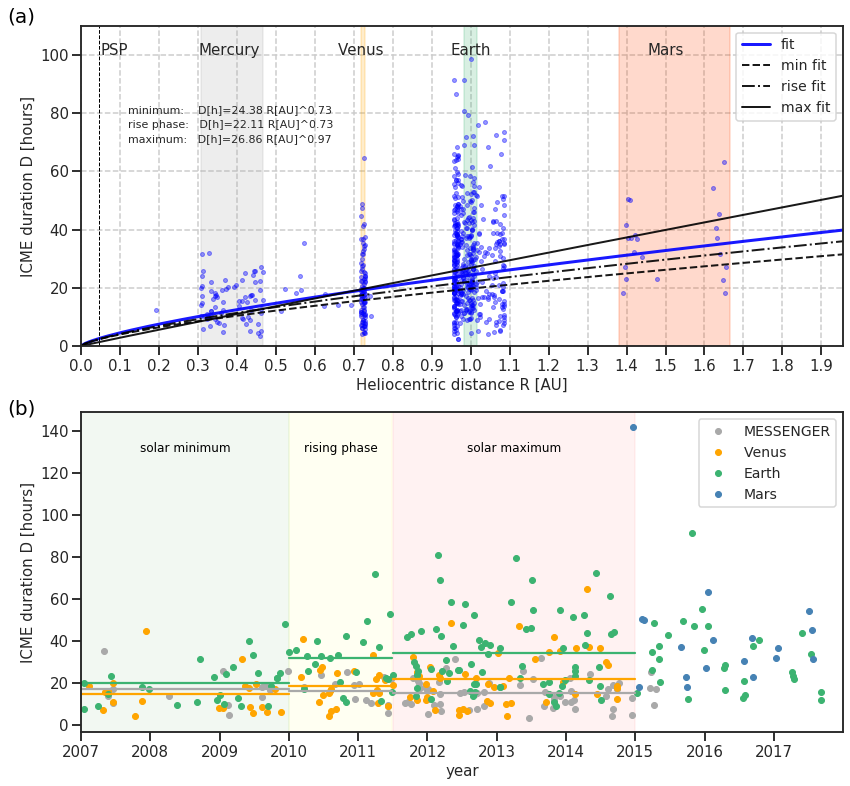

In [52]:
#plot results
sns.set_context("talk")                
#sns.set_style("darkgrid")  
sns.set_style("ticks",{'grid.linestyle': '--'})

fig=plt.figure(1,figsize=(12,11	))
fsize=15


ax1 = plt.subplot2grid((2,1), (0, 0))

plt.plot(ic.mo_sc_heliodistance,ic.icme_duration,'o',color='blue',markersize=4, alpha=0.4)
#for plotting min/rise/max differently
#plt.plot(sc_heliodistance[iall_min],icme_durations[iall_min],'o',color='dimgre',markersize=3, alpha=0.4,label='D min')
#plt.plot(sc_heliodistance[iall_rise],icme_durations[iall_rise],'o',color='grey',markersize=3, alpha=0.7,label='D rise')
#plt.plot(sc_heliodistance[iall_max],icme_durations[iall_max],'o',color='black',markersize=3, alpha=0.8,label='D max')

#plot fits
plt.plot(xfit,yfit_all,'-',color='blue', lw=3, alpha=0.9,label='fit')
plt.plot(xfit,yfit_min,'--',color='black', lw=2, alpha=0.9,label='min fit')
plt.plot(xfit,yfit_rise,'-.',color='black', lw=2, alpha=0.9,label='rise fit')
plt.plot(xfit,yfit_max,'-',color='black', lw=2, alpha=0.9,label='max fit')


label_level=85

#plt.annotate('overall:',xy=(0.06,label_level),fontsize=11)
#plt.annotate('D[h]={:.2f} R[AU]'.format(durfit_f[0]),xy=(0.15,label_level),fontsize=11)
plt.annotate('minimum:    D[h]={:.2f} R[AU]^{:.2f} '.format(param_all[0][0],param_all[0][1]),xy=(0.12,label_level-5),fontsize=11)
plt.annotate('rise phase:   D[h]={:.2f} R[AU]^{:.2f} '.format(param_rise[0][0],param_rise[0][1]),xy=(0.12,label_level-10),fontsize=11)
plt.annotate('maximum:   D[h]={:.2f} R[AU]^{:.2f} '.format(param_max[0][0],param_max[0][1]),xy=(0.12,label_level-15),fontsize=11)

#planet limits
plt.axvspan(np.min(pos.mars[0]),np.max(pos.mars[0]), color='orangered', alpha=0.2)
plt.axvspan(np.min(pos.mercury[0]),np.max(pos.mercury[0]), color='darkgrey', alpha=0.2)
plt.axvspan(np.min(pos.venus[0]),np.max(pos.venus[0]), color='orange', alpha=0.2)
plt.axvspan(np.min(pos.earth[0]),np.max(pos.earth[0]), color='mediumseagreen', alpha=0.2)
#plt.axvspan(np.min(pos.sta[0]),np.max(pos.sta[0]), color='red', alpha=0.2)  #STEREO-A
#plt.axvspan(np.min(pos.stb[0]),np.max(pos.stb[0]), color='blue', alpha=0.2)  #STEREO-B
#Parker Probe minimum
plt.plot([0.046,0.046],[0,110], color='black', linestyle='--', linewidth=1)

#label_level=100
label_level=100

plt.annotate('Mars', xy=(1.5,label_level), ha='center',fontsize=fsize)
plt.annotate('Mercury', xy=(0.38,label_level), ha='center',fontsize=fsize)
plt.annotate('Venus', xy=(0.72,label_level), ha='center',fontsize=fsize)
plt.annotate('Earth', xy=(1,label_level), ha='center',fontsize=fsize)
plt.annotate('PSP', xy=(0.05,label_level), ha='left',fontsize=fsize)

ax1.set_xticks(np.arange(0,2,0.1))
plt.xlim(0,max(ic.mo_sc_heliodistance)+0.3)
plt.ylim(0,110)

plt.legend(loc=1,fontsize=fsize-1)
plt.xlabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.ylabel('ICME duration D [hours]',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
plt.grid()

#panel labels
plt.figtext(0.01,0.98,'(a)',color='black', fontsize=fsize+5, ha='left')
plt.figtext(0.01,0.485,'(b)',color='black', fontsize=fsize+5, ha='left')
plt.tight_layout()




#################################### plot 

ax2 = plt.subplot2grid((2,1), (1, 0))
markers=6
linew=0

#plot durations for all planets
ax2.plot_date(ic.icme_start_time[mesi],ic.icme_duration[mesi], \
    'o',color='darkgrey',markersize=markers,linestyle='-',linewidth=linew,label='MESSENGER')
ax2.plot_date(ic.icme_start_time[vexi],ic.icme_duration[vexi], \
    'o',color='orange',markersize=markers,linestyle='-',linewidth=linew, label='Venus')
ax2.plot_date(ic.icme_start_time[wini],ic.icme_duration[wini], \
    'o',color='mediumseagreen',markersize=markers, linestyle='-', linewidth=linew, label='Earth')
ax2.plot_date(ic.icme_start_time[mavi],ic.icme_duration[mavi], \
    'o',color='steelblue',markersize=markers,linestyle='-',linewidth=linew, label='Mars')
#ax2.plot_date(xgfit,ygfit,markersize=0,linestyle='-',color='mediumseagreen',linewidth=2,label='Wind Gaussian fit')




#limits solar min/rise/maxax2.set_ylim(0,80)
vlevel=130
spanalpha=0.05

plt.axvspan(minstart,minend, color='green', alpha=spanalpha)
plt.annotate('solar minimum',xy=(minstart_num+(minend_num-minstart_num)/2,vlevel),color='black', ha='center',fontsize=12)
#plt.annotate('<',xy=(minstart_num+10,vlevel),ha='left')
#plt.annotate('>',xy=(minend_num-10,vlevel),ha='right')

plt.axvspan(risestart,riseend, color='yellow', alpha=spanalpha)
plt.annotate('rising phase',xy=(risestart_num+(riseend_num-risestart_num)/2,vlevel),color='black', ha='center',fontsize=12)
#plt.annotate('<',xy=(risestart_num+10,vlevel),ha='left')
#plt.annotate('>',xy=(riseend_num-10,vlevel),ha='right')

plt.axvspan(maxstart,maxend, color='red', alpha=spanalpha)
plt.annotate('solar maximum',xy=(maxstart_num+(maxend_num-maxstart_num)/2,vlevel),color='black', ha='center',fontsize=12)
#plt.annotate('<',xy=(maxstart_num+10,vlevel),ha='left')
#plt.annotate('>',xy=(maxend_num,vlevel),ha='right')


#plot means as horizontal lines for each sub interval
plt.plot_date( [minstart,minend], [np.mean(ic.icme_duration[wini_min]),np.mean(ic.icme_duration[wini_min])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [minstart,minend], [np.mean(ic.icme_duration[vexi_min]),np.mean(ic.icme_duration[vexi_min])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [minstart,minend], [np.mean(ic.icme_duration[mesi_min]),np.mean(ic.icme_duration[mesi_min])], color='darkgrey', linestyle='-', markersize=0) 

plt.plot_date( [risestart,riseend], [np.mean(ic.icme_duration[wini_rise]),np.mean(ic.icme_duration[wini_rise])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [risestart,riseend], [np.mean(ic.icme_duration[vexi_rise]),np.mean(ic.icme_duration[vexi_rise])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [risestart,riseend], [np.mean(ic.icme_duration[mesi_rise]),np.mean(ic.icme_duration[mesi_rise])], color='darkgrey', linestyle='-', markersize=0) 

plt.plot_date( [maxstart,maxend], [np.mean(ic.icme_duration[wini_max]),np.mean(ic.icme_duration[wini_max])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [maxstart,maxend], [np.mean(ic.icme_duration[vexi_max]),np.mean(ic.icme_duration[vexi_max])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [maxstart,maxend], [np.mean(ic.icme_duration[mesi_max]),np.mean(ic.icme_duration[mesi_max])], color='darkgrey', linestyle='-', markersize=0) 

plt.xlim(parse_time('2007-01-01').datetime, parse_time('2017-12-31').datetime)
plt.ylabel('ICME duration D [hours]',fontsize=fsize)
plt.xlabel('year',fontsize=fsize)
plt.tight_layout()
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
plt.legend(loc=1,fontsize=fsize-1)


plt.savefig('results/plots_stats/icme_duration_distance_time_paper.pdf', dpi=300)
plt.savefig('results/plots_stats/icme_duration_distance_time_paper.png', dpi=300)

## 3. Bfield vs distance

### 3a power law fits

In [53]:
# xfit starts here at 2 Rs  because there should not be a 0 for the power law fits
xfit=np.linspace(2*Rs_in_AU,2,1000)

print('3a Bfield vs distance fits')

#power law fit bmean
scr=ic.mo_sc_heliodistance
scb=ic.mo_bmean
param_all = scipy.optimize.curve_fit(hs.powerlaw, scr, scb)
yfit_all=hs.powerlaw(xfit,param_all[0][0],param_all[0][1])
print('bmean all:        ',np.round(param_all[0][0]),' x ^', np.round(param_all[0][1],2))

#power law fit bmax 
scr=ic.mo_sc_heliodistance
scb=ic.mo_bmax
param_all_max = scipy.optimize.curve_fit(hs.powerlaw, scr, scb)
yfit_all_max=hs.powerlaw(xfit,param_all_max[0][0],param_all_max[0][1])
print('bmax all:        ',np.round(param_all_max[0][0]),' x ^', np.round(param_all_max[0][1],2))


#power law fit for solar minimum durations
scr=ic.mo_sc_heliodistance[iall_min]
scb=ic.mo_bmean[iall_min]
param_min = scipy.optimize.curve_fit(hs.powerlaw, scr, scb)
yfit_min=hs.powerlaw(xfit,param_min[0][0],param_min[0][1])
print('bmean min:        ',np.round(param_min[0][0]),' x ^', np.round(param_min[0][1],2))


#power law fit for solar minimum durations
scr=ic.mo_sc_heliodistance[iall_rise]
scb=ic.mo_bmean[iall_rise]
param_rise = scipy.optimize.curve_fit(hs.powerlaw, scr, scb)
yfit_rise=hs.powerlaw(xfit,param_rise[0][0],param_rise[0][1])
print('bmean rise:        ',np.round(param_rise[0][0]),' x ^', np.round(param_rise[0][1],2))

#power law fit for solar minimum durations
scr=ic.mo_sc_heliodistance[iall_max]
scb=ic.mo_bmean[iall_max]
param_max = scipy.optimize.curve_fit(hs.powerlaw, scr, scb)
yfit_max=hs.powerlaw(xfit,param_max[0][0],param_max[0][1])
print('bmean max:        ',np.round(param_max[0][0]),' x ^', np.round(param_max[0][1],2))



#for the bmean fit, append one value for the coronal field 
#patsourakos georgoulis 2016: 0.03 G for 10 Rs #10^5 nT is 1 Gauss

#power law fit bmean with solar data point
scr=np.append(ic.mo_sc_heliodistance,10*Rs_in_AU)
scb1=np.append(ic.mo_bmean,10**5*0.03) 
param_all_sun = scipy.optimize.curve_fit(hs.powerlaw, scr, scb1)
yfit_all_sun=hs.powerlaw(xfit,param_all_sun[0][0],param_all_sun[0][1])
print('bmean all with sun:        ',np.round(param_all_sun[0][0]),' x ^', np.round(param_all_sun[0][1],2))

#power law fit bmax with solar data point
scr=np.append(ic.mo_sc_heliodistance,10*Rs_in_AU)
scb2=np.append(ic.mo_bmax,10**5*0.03) 
param_all_sun_max = scipy.optimize.curve_fit(hs.powerlaw, scr, scb2)
yfit_all_sun_max=hs.powerlaw(xfit,param_all_sun_max[0][0],param_all_sun_max[0][1])
print('bmax all with sun:        ',np.round(param_all_sun_max[0][0]),' x ^', np.round(param_all_sun_max[0][1],2))

3a Bfield vs distance fits
bmean all:         11.0  x ^ -1.51
bmax all:         15.0  x ^ -1.5
bmean min:         9.0  x ^ -1.29
bmean rise:         10.0  x ^ -1.67
bmean max:         10.0  x ^ -1.66
bmean all with sun:         7.0  x ^ -1.96
bmax all with sun:         12.0  x ^ -1.79


### 3a plot results

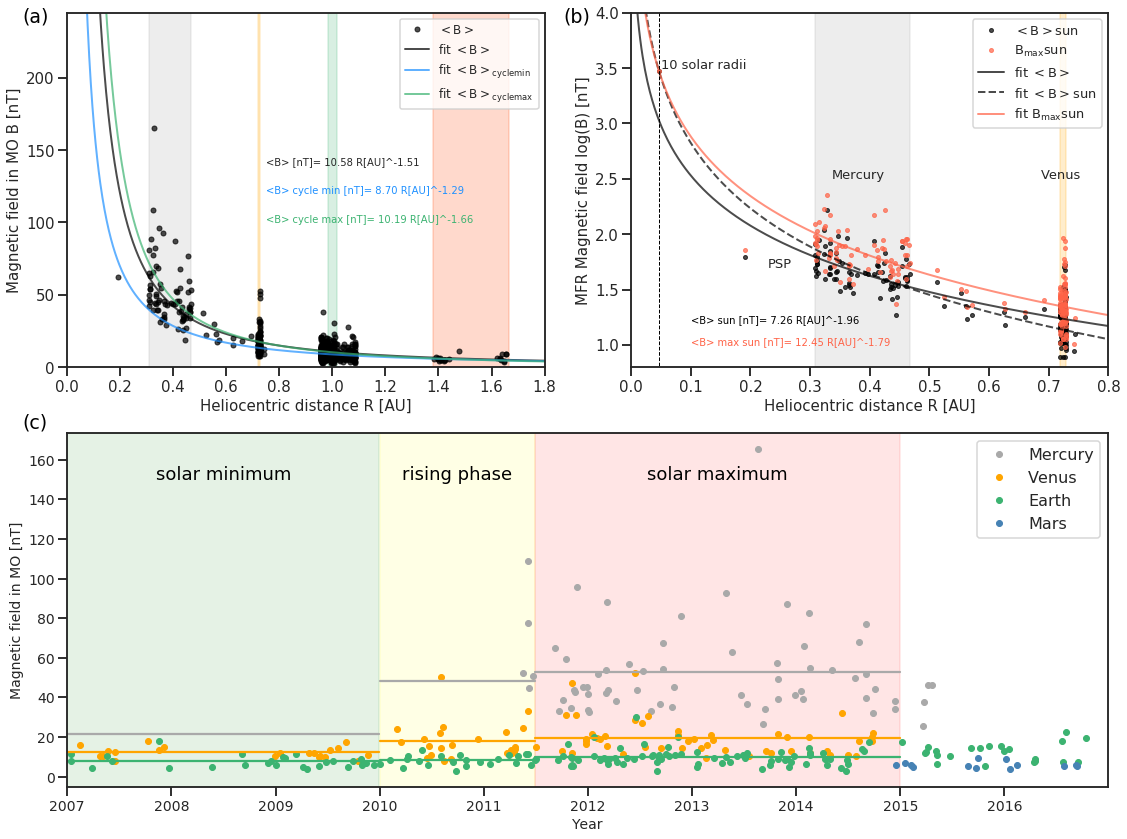

In [54]:
#plot results
sns.set_context("talk")     
sns.set_style("ticks",{'grid.linestyle': '--'})
fig=plt.figure(2,figsize=(16,12))
fsize=15
ax1 = plt.subplot2grid((2,2), (0, 0))



################# plots 3a
plt.plot(ic.mo_sc_heliodistance,ic.mo_bmean,'o',color='black',markersize=5, alpha=0.7,label='$\mathregular{<B>}$')
plt.plot(xfit,yfit_all,'-',color='black', lw=2, alpha=0.7,label='fit $\mathregular{<B>}$')
plt.plot(xfit,yfit_min,'-',color='dodgerblue', lw=2, alpha=0.7,label='fit $\mathregular{ <B>_{cycle min}}$')
plt.plot(xfit,yfit_max,'-',color='mediumseagreen', lw=2, alpha=0.7,label='fit $ \mathregular{<B>_{cycle max} }$')


#plt.plot(ic.mo_sc_heliodistance,ic.mo_bmax,'o',color='dodgerblue',markersize=5, alpha=0.7,label='$\mathregular{B_{max}}$')
#plt.plot(xfit,bmaxfitfun,'-',color='dodgerblue', lw=2, alpha=0.7,label='$\mathregular{B_{max} \\ fit}$')

#plt.text(1.1,120,'$\mathregular{<B> [nT]= {:.2f} R[AU]^{{:.2f}}}$'.format(10**bmeanfit[1],bmeanfit[0]), fontsize=10)
plt.text(0.75,140,r'<B> [nT]= {:.2f} R[AU]^{:.2f}'.format(param_all[0][0],param_all[0][1]), fontsize=10)
plt.text(0.75,120,r'<B> cycle min [nT]= {:.2f} R[AU]^{:.2f}'.format(param_min[0][0],param_min[0][1]), fontsize=10,color='dodgerblue')
plt.text(0.75,100,r'<B> cycle max [nT]= {:.2f} R[AU]^{:.2f}'.format(param_max[0][0],param_max[0][1]), fontsize=10,color='mediumseagreen')



#planet limits
plt.axvspan(np.min(pos.mars[0]),np.max(pos.mars[0]), color='orangered', alpha=0.2)
#plt.figtext(0.8,0.8,'Mars',color='orangered')
plt.axvspan(np.min(pos.mercury[0]),np.max(pos.mercury[0]), color='darkgrey', alpha=0.2)
#plt.figtext(0.25,0.8,'Mercury',color='darkgrey')
plt.axvspan(np.min(pos.venus[0]),np.max(pos.venus[0]), color='orange', alpha=0.2)
#plt.figtext(0.42,0.8,'Venus',color='orange')
plt.axvspan(np.min(pos.earth[0]),np.max(pos.earth[0]), color='mediumseagreen', alpha=0.2)
#plt.figtext(0.6,0.8,'Earth',color='mediumseagreen')

#plt.figtext(0.65,0.2,' D[h]={:.2f} R[AU] + {:.2f}'.format(durfit[0],durfit[1]))
plt.xlim(0,1.8)
plt.ylim(0,max(ic.mo_bmax)+20)

plt.legend(loc=1,fontsize=fsize-3)

plt.xlabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.ylabel('Magnetic field in MO B [nT]',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
#plt.grid()






######################## 3b logarithmic plot with Sun


ax3 = plt.subplot2grid((2,2), (0, 1))

plt.plot(scr,np.log10(scb1),'o',color='black',markersize=4, alpha=0.7,label='$\mathregular{<B> sun}$')
plt.plot(scr,np.log10(scb2),'o',color='tomato',markersize=4, alpha=0.7,label='$\mathregular{B_{max} sun}$')
plt.plot(xfit,np.log10(yfit_all),'-',color='black', lw=2, alpha=0.7,label='fit $\mathregular{<B>}$')
plt.plot(xfit,np.log10(yfit_all_sun),'--',color='black', lw=2, alpha=0.7,label='fit $\mathregular{<B> sun}$')
plt.plot(xfit,np.log10(yfit_all_sun_max),'-',color='tomato', lw=2, alpha=0.7,label='fit $\mathregular{ B_{max} sun}$')

# planet labels and shades
ax3.annotate('Mercury', xy=(0.38,2.5), ha='center',fontsize=fsize-2)
ax3.annotate('Venus', xy=(0.72,2.5), ha='center',fontsize=fsize-2)
#ax3.annotate('Earth', xy=(1,2.8), ha='center',fontsize=fsize-2)
#ax3.annotate('Mars', xy=(1.5,2.8), ha='center',fontsize=fsize-2)
plt.plot([0.046,0.046],[0,10], color='black', linestyle='--', linewidth=1)
ax3.annotate('10 solar radii', xy=(0.05,3.5), ha='left',fontsize=fsize-2)
ax3.annotate('PSP', xy=(0.25,1.7), ha='center',fontsize=fsize-2)


plt.axvspan(np.min(pos.mars[0]),np.max(pos.mars[0]), color='orangered', alpha=0.2)
plt.axvspan(np.min(pos.mercury[0]),np.max(pos.mercury[0]), color='darkgrey', alpha=0.2)
plt.axvspan(np.min(pos.venus[0]),np.max(pos.venus[0]), color='orange', alpha=0.2)
#plt.axvspan(np.min(pos.earth[0]),np.max(pos.earth[0]), color='mediumseagreen', alpha=0.2)


plt.text(0.1,1.2,r'<B> sun [nT]= {:.2f} R[AU]^{:.2f}'.format(param_all_sun[0][0],param_all_sun[0][1]), fontsize=10,color='black')
plt.text(0.1,1.0,r'<B> max sun [nT]= {:.2f} R[AU]^{:.2f}'.format(param_all_sun_max[0][0],param_all_sun_max[0][1]), fontsize=10,color='tomato')




plt.xlim(0,0.8)
plt.ylim(0.8,4.0)
plt.legend(loc=1,fontsize=fsize-2)
plt.xlabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.ylabel('MFR Magnetic field log(B) [nT]',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 







################################# 3c MO B vs. time
ax2 = plt.subplot2grid((2,2), (1, 0), colspan=2)
markers=6
linew=0
plt.plot_date(ic.icme_start_time[merci],ic.mo_bmean[merci],'o',color='darkgrey',markersize=markers,linestyle='-',linewidth=linew,label='Mercury')
plt.plot_date(ic.icme_start_time[vexi],ic.mo_bmean[vexi],'o',color='orange',markersize=markers,linestyle='-',linewidth=linew, label='Venus')
plt.plot_date(ic.icme_start_time[wini],ic.mo_bmean[wini],'o',color='mediumseagreen',markersize=markers, linestyle='-', linewidth=linew, label='Earth')
plt.plot_date(ic.icme_start_time[mavi],ic.mo_bmean[mavi],'o',color='steelblue',markersize=markers,linestyle='-',linewidth=linew, label='Mars')


plt.legend(loc=1,fontsize=fsize-2)
#limits solar min/rise/max
vlevel=150
plt.axvspan(minstart,minend, color='green', alpha=0.1)
plt.annotate('solar minimum',xy=(minstart+(minend-minstart)/2,vlevel),color='black', ha='center')
plt.axvspan(risestart,riseend, color='yellow', alpha=0.1)
plt.annotate('rising phase',xy=(risestart+(riseend-risestart)/2,vlevel),color='black', ha='center')
plt.axvspan(maxstart,maxend, color='red', alpha=0.1)
plt.annotate('solar maximum',xy=(maxstart+(maxend-maxstart)/2,vlevel),color='black', ha='center')


plt.plot_date( [minstart,minend], [np.mean(ic.mo_bmean[wini_min]), \
               np.mean(ic.mo_bmean[wini_min])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [minstart,minend], [np.mean(ic.mo_bmean[vexi_min]), \
               np.mean(ic.mo_bmean[vexi_min])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [minstart,minend], [np.mean(ic.mo_bmean[mesi_min]), \
               np.mean(ic.mo_bmean[mesi_min])], color='darkgrey', linestyle='-', markersize=0) 

plt.plot_date( [risestart,riseend], [np.mean(ic.mo_bmean[wini_rise]), \
               np.mean(ic.mo_bmean[wini_rise])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [risestart,riseend], [np.mean(ic.mo_bmean[vexi_rise]), \
               np.mean(ic.mo_bmean[vexi_rise])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [risestart,riseend], [np.mean(ic.mo_bmean[mesi_rise]), \
               np.mean(ic.mo_bmean[mesi_rise])], color='darkgrey', linestyle='-', markersize=0) 

plt.plot_date( [maxstart,maxend], [np.mean(ic.mo_bmean[wini_max]), \
               np.mean(ic.mo_bmean[wini_max])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [maxstart,maxend], [np.mean(ic.mo_bmean[vexi_max]), \
               np.mean(ic.mo_bmean[vexi_max])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [maxstart,maxend], [np.mean(ic.mo_bmean[mesi_max]), \
               np.mean(ic.mo_bmean[mesi_max])], color='darkgrey', linestyle='-', markersize=0) 

plt.ylabel('Magnetic field in MO [nT]', fontsize=fsize)
plt.xlabel('Year', fontsize=fsize)
fsize=14
plt.xlim(parse_time('2007-01-01').datetime, parse_time('2016-12-31').datetime)

plt.ylabel('Magnetic field in MO [nT]', fontsize=fsize)
plt.xlabel('Year', fontsize=fsize)
plt.tight_layout()
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
plt.legend(loc=1,fontsize=fsize+2)

#panel labels
plt.figtext(0.03,0.96,'(a)',color='black', fontsize=fsize+5, ha='left')
plt.figtext(0.50,0.96,'(b)',color='black', fontsize=fsize+5, ha='left')
plt.figtext(0.03,0.49,'(c)',color='black', fontsize=fsize+5, ha='left')


#+++ add indicator for missions at planet durations



plt.tight_layout()
plt.savefig('results/plots_stats/icme_total_field_distance_time_paper.pdf', dpi=300)
plt.savefig('results/plots_stats/icme_total_field_distance_time_paper.png', dpi=300)
#plt.savefig('results/plots_stats/icme_total_field_distance_time_paper.jpg', dpi=300)


### 3c magnetic field results

In [55]:
########################### RESULTS Bfield
print()
print('Magnetic field B ic.mo_bmean results, mean +/- std [nT]')

print()
print('Mercury ', round(np.mean(ic.mo_bmean[merci]),1),' +/- ', round(np.std(ic.mo_bmean[merci]),1))
#print('min     ', round(np.mean(ic.mo_bmean[merci_min]),1), ' +/- ', round(np.std(ic.mo_bmean[merci_min]),1))
print('min      no events')
print('rise    ', round(np.mean(ic.mo_bmean[merci_rise]),1), ' +/- ', round(np.std(ic.mo_bmean[merci_rise]),1))
print('max     ', round(np.mean(ic.mo_bmean[merci_max]),1), ' +/- ', round(np.std(ic.mo_bmean[merci_max]),1))

print()
print('Venus   ', round(np.mean(ic.mo_bmean[vexi]),1),' +/- ', round(np.std(ic.mo_bmean[vexi]),1))
print('min     ', round(np.mean(ic.mo_bmean[vexi_min]),1), ' +/- ', round(np.std(ic.mo_bmean[vexi_min]),1))
print('rise    ', round(np.mean(ic.mo_bmean[vexi_rise]),1), ' +/- ', round(np.std(ic.mo_bmean[vexi_rise]),1))
print('max     ', round(np.mean(ic.mo_bmean[vexi_max]),1), ' +/- ', round(np.std(ic.mo_bmean[vexi_max]),1))

print()
print('Earth   ', round(np.mean(ic.mo_bmean[wini]),1),' +/- ', round(np.std(ic.mo_bmean[wini]),1))
print('min     ', round(np.mean(ic.mo_bmean[wini_min]),1), ' +/- ', round(np.std(ic.mo_bmean[wini_min]),1))
print('rise    ', round(np.mean(ic.mo_bmean[wini_rise]),1), ' +/- ', round(np.std(ic.mo_bmean[wini_rise]),1))
print('max     ', round(np.mean(ic.mo_bmean[wini_max]),1), ' +/- ', round(np.std(ic.mo_bmean[wini_max]),1))

print()
print('Mars only declining phase')
print('decl    ',round(np.mean(ic.mo_bmean[mavi]),1),' +/- ', round(np.std(ic.mo_bmean[mavi]),1))





Magnetic field B ic.mo_bmean results, mean +/- std [nT]

Mercury  52.9  +/-  22.7
min      no events
rise     66.8  +/-  23.8
max      52.6  +/-  22.6

Venus    17.4  +/-  8.3
min      12.3  +/-  2.7
rise     18.2  +/-  9.2
max      19.3  +/-  8.6

Earth    9.8  +/-  4.1
min      7.7  +/-  3.1
rise     8.3  +/-  2.5
max      9.9  +/-  4.2

Mars only declining phase
decl     6.0  +/-  1.5


## 4. Time spent by planet inside CMEs

### 4a get time inside ICME percentage for full time range


In [56]:
#check all data points in the magnetic field data which are not NaN
win_data_ind=np.where(np.isnan(win.bt)==False)[0]
sta_data_ind=np.where(np.isnan(sta.bt)==False)[0]
stb_data_ind=np.where(np.isnan(stb.bt)==False)[0]
vex_data_ind=np.where(np.isnan(vex.bt)==False)[0]
mav_data_ind=np.where(np.isnan(mav.bt)==False)[0]
mes_data_ind=np.where(np.isnan(mes.bt)==False)[0]
merc_data_ind=np.where(np.logical_and(np.isnan(mes.bt)==False,mes.time > parse_time('2011-03-18').datetime ))[0]

print('Total data points')
print('Mercury: ', np.size(merc_data_ind))
print('Venus:', np.size(vex_data_ind))
print('Earth:', np.size(win_data_ind))
print('Mars:', np.size(mav_data_ind))

#go through all spacecraft to count ICME data points, take files produced by icmecat.py


print()
#initialize arrays as size is not known
win_icme_ind=np.int32(0)
sta_icme_ind=np.int32(0)
stb_icme_ind=np.int32(0)
vex_icme_ind=np.int32(0)
mes_icme_ind=np.int32(0)
mav_icme_ind=np.int32(0)
merc_icme_ind=np.int32(0)

print('get arrays including all icme indices')
names=['Wind', 'STEREO-A', 'STEREO-B','MAVEN', 'VEX', 'MESSENGER']

for name in names:
    fileind='icmecat/indices_icmecat/ICMECAT_indices_'+name+'.p'
    print('file: ',fileind)
    #get indices of events for this spaceccrat
    [icme_start_ind, mo_start_ind,mo_end_ind]=pickle.load(open(fileind, 'rb'))  
    for k in np.arange(np.size(icme_start_ind)):
        #print(mo_end_ind[k]-icme_start_ind[k])
        #print(np.arange(icme_start_ind[k],mo_end_ind[k],1))
        if name=='Wind':      win_icme_ind=np.append(win_icme_ind,np.arange(icme_start_ind[k],mo_end_ind[k],1))
        if name=='STEREO-A':  sta_icme_ind=np.append(sta_icme_ind,np.arange(icme_start_ind[k],mo_end_ind[k],1))
        if name=='STEREO-B':  stb_icme_ind=np.append(stb_icme_ind,np.arange(icme_start_ind[k],mo_end_ind[k],1))
        if name=='VEX':       vex_icme_ind=np.append(vex_icme_ind,np.arange(icme_start_ind[k],mo_end_ind[k],1))
        if name=='MESSENGER': mes_icme_ind=np.append(mes_icme_ind,np.arange(icme_start_ind[k],mo_end_ind[k],1))
        if name=='MAVEN':     mav_icme_ind=np.append(mav_icme_ind,np.arange(icme_start_ind[k],mo_end_ind[k],1))

                                  

#get ICME indices for Mercury after orbit insertion
merc_icme_ind=mes_icme_ind[np.where(mes_icme_ind > merc_data_ind[0])[0] ]  
    
print('Total data points inside ICMEs')
print('Mercury: ', np.size(merc_icme_ind))
print('Venus:', np.size(vex_icme_ind))
print('Earth:', np.size(win_icme_ind))
print('Mars:', np.size(mav_icme_ind))



print()
print()
print('Percentage of time inside ICMEs average over full time range')    
print('planets')
print('Mercury MESSENGER:',np.round((np.size(merc_icme_ind)/np.size(merc_data_ind)*100),1))
print('Venus VEX:         ',np.round((np.size(vex_icme_ind)/np.size(vex_data_ind)*100),1))
print('Earth Wind:        ',np.round((np.size(win_icme_ind)/np.size(win_data_ind)*100),1))
print('Mars MAVEN:        ',np.round((np.size(mes_icme_ind)/np.size(mes_data_ind)*100),1))
print()
print('solar wind')
print('MESSENGER all data:         ',np.round((np.size(mes_icme_ind)/np.size(mes_data_ind)*100),1))
print('STB:               ',np.round((np.size(stb_icme_ind)/np.size(stb_data_ind)*100),1))
print('STA:               ',np.round((np.size(sta_icme_ind)/np.size(sta_data_ind)*100),1))

Total data points
Mercury:  1316875
Venus: 3329639
Earth: 5659598
Mars: 3795

get arrays including all icme indices
file:  icmecat/indices_icmecat/ICMECAT_indices_Wind.p
file:  icmecat/indices_icmecat/ICMECAT_indices_STEREO-A.p
file:  icmecat/indices_icmecat/ICMECAT_indices_STEREO-B.p
file:  icmecat/indices_icmecat/ICMECAT_indices_MAVEN.p
file:  icmecat/indices_icmecat/ICMECAT_indices_VEX.p
file:  icmecat/indices_icmecat/ICMECAT_indices_MESSENGER.p
Total data points inside ICMEs
Mercury:  59140
Venus: 109450
Earth: 289867
Mars: 167


Percentage of time inside ICMEs average over full time range
planets
Mercury MESSENGER: 4.5
Venus VEX:          3.3
Earth Wind:         5.1
Mars MAVEN:         3.1

solar wind
MESSENGER all data:          3.1
STB:                6.6
STA:                5.7


### 4b get time inside ICME percentage for yearly time range

In [57]:
############# make array for time inside percentages

inside_win_perc=np.zeros(np.size(yearly_mid_times))
inside_win_perc.fill(np.nan)

inside_sta_perc=np.zeros(np.size(yearly_mid_times))
inside_sta_perc.fill(np.nan)

inside_stb_perc=np.zeros(np.size(yearly_mid_times))
inside_stb_perc.fill(np.nan)

inside_mes_perc=np.zeros(np.size(yearly_mid_times))
inside_mes_perc.fill(np.nan)

inside_merc_perc=np.zeros(np.size(yearly_mid_times))
inside_merc_perc.fill(np.nan)

inside_vex_perc=np.zeros(np.size(yearly_mid_times))
inside_vex_perc.fill(np.nan)

inside_mav_perc=np.zeros(np.size(yearly_mid_times))
inside_mav_perc.fill(np.nan)



#count ratio of datapoint inside ICME to all available datapoints for each year, Wind, STA, STB, Mercury, MESSENGER, VEX, MAVEN

for i in range(np.size(yearly_mid_times)):

    thisyear_icme=np.where(np.logical_and((win.time[win_icme_ind] > yearly_start_times_d[i]),(win.time[win_icme_ind] < yearly_end_times_d[i])))
    thisyear_data=np.where(np.logical_and((win.time[win_data_ind] > yearly_start_times_d[i]),(win.time[win_data_ind] < yearly_end_times_d[i])))
    if np.size(thisyear_data) >0:inside_win_perc[i]=np.round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((sta.time[sta_icme_ind] > yearly_start_times_d[i]),(sta.time[sta_icme_ind] < yearly_end_times_d[i])))
    thisyear_data=np.where(np.logical_and((sta.time[sta_data_ind] > yearly_start_times_d[i]),(sta.time[sta_data_ind] < yearly_end_times_d[i])))
    if np.size(thisyear_data) >0:inside_sta_perc[i]=np.round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((stb.time[stb_icme_ind] > yearly_start_times_d[i]),(stb.time[stb_icme_ind] < yearly_end_times_d[i])))
    thisyear_data=np.where(np.logical_and((stb.time[stb_data_ind] > yearly_start_times_d[i]),(stb.time[stb_data_ind] < yearly_end_times_d[i])))
    if np.size(thisyear_data) >0:inside_stb_perc[i]=np.round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mes.time[mes_icme_ind] > yearly_start_times_d[i]),(mes.time[mes_icme_ind] < yearly_end_times_d[i])))
    thisyear_data=np.where(np.logical_and((mes.time[mes_data_ind] > yearly_start_times_d[i]),(mes.time[mes_data_ind] < yearly_end_times_d[i])))
    if np.size(thisyear_data) >0:inside_mes_perc[i]=np.round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((vex.time[vex_icme_ind] > yearly_start_times_d[i]),(vex.time[vex_icme_ind] < yearly_end_times_d[i])))
    thisyear_data=np.where(np.logical_and((vex.time[vex_data_ind] > yearly_start_times_d[i]),(vex.time[vex_data_ind] < yearly_end_times_d[i])))
    if np.size(thisyear_data) >0:inside_vex_perc[i]=np.round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mes.time[merc_icme_ind] > yearly_start_times_d[i]),(mes.time[merc_icme_ind] < yearly_end_times_d[i])))
    thisyear_data=np.where(np.logical_and((mes.time[merc_data_ind] > yearly_start_times_d[i]),(mes.time[merc_data_ind] < yearly_end_times_d[i])))
    if np.size(thisyear_data) >0: inside_merc_perc[i]=np.round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mav.time[mav_icme_ind] > yearly_start_times_d[i]),(mav.time[mav_icme_ind] < yearly_end_times_d[i])))
    thisyear_data=np.where(np.logical_and((mav.time[mav_data_ind] > yearly_start_times_d[i]),(mav.time[mav_data_ind] < yearly_end_times_d[i])))
    if np.size(thisyear_data) >0: inside_mav_perc[i]=np.round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)


print()
print()
print('Percentage of time inside ICMEs for each year')    
print()
print('Mercury MESSENGER: ',inside_merc_perc)
print('Venus VEX:         ',inside_vex_perc)
print('Earth Wind:        ',inside_win_perc)
print('Mars MAVEN:        ',inside_mav_perc)
print()
print('MESSENGER:         ',inside_mes_perc)
print('STB:               ',inside_stb_perc)
print('STA:               ',inside_sta_perc)



Percentage of time inside ICMEs for each year

Mercury MESSENGER:  [nan nan nan nan 4.7 5.1 4.  4.2 3.8 nan nan]
Venus VEX:          [2.  0.1 2.1 3.8 4.9 3.9 4.7 5.4 nan nan nan]
Earth Wind:         [ 1.3  1.   4.   5.   7.3 11.9  8.2  7.1  6.1  3.   2. ]
Mars MAVEN:         [ nan  nan  nan  nan  nan  nan  nan 15.3  3.5  3.5  4.6]

MESSENGER:          [2.3 0.7 2.1 1.4 4.1 5.1 4.  4.2 3.8 nan nan]
STB:                [ 0.9  1.7  3.4  4.8  7.7 12.  11.2 12.1  nan  nan  nan]
STA:                [ 1.1  1.3  3.4  3.9 10.3 13.7 15.7 15.8  0.7  3.5  3.7]


### 4c get time inside ICME percentage for solar cycle phases

In [58]:
cycle_start_times=parse_time([minstart, risestart, maxstart]).datetime
cycle_end_times=parse_time([minend, riseend, maxend]).datetime

############################################


inside_win_cycle=np.zeros(np.size(cycle_start_times))
inside_win_cycle.fill(np.nan)

inside_sta_cycle=np.zeros(np.size(cycle_start_times))
inside_sta_cycle.fill(np.nan)

inside_stb_cycle=np.zeros(np.size(cycle_start_times))
inside_stb_cycle.fill(np.nan)

inside_mes_cycle=np.zeros(np.size(cycle_start_times))
inside_mes_cycle.fill(np.nan)

inside_merc_cycle=np.zeros(np.size(cycle_start_times))
inside_merc_cycle.fill(np.nan)

inside_vex_cycle=np.zeros(np.size(cycle_start_times))
inside_vex_cycle.fill(np.nan)

inside_mav_cycle=np.zeros(np.size(cycle_start_times))
inside_mav_cycle.fill(np.nan)


#count ratio of datapoint inside ICME to all available datapoints for each year, Wind, STA, STB, Mercury, MESSENGER, VEX, MAVEN

for i in range(np.size(cycle_start_times)):

    thisyear_icme=np.where(np.logical_and((win.time[win_icme_ind] > cycle_start_times[i]),(win.time[win_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((win.time[win_data_ind] > cycle_start_times[i]),(win.time[win_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_win_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((sta.time[sta_icme_ind] > cycle_start_times[i]),(sta.time[sta_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((sta.time[sta_data_ind] > cycle_start_times[i]),(sta.time[sta_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_sta_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((stb.time[stb_icme_ind] > cycle_start_times[i]),(stb.time[stb_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((stb.time[stb_data_ind] > cycle_start_times[i]),(stb.time[stb_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_stb_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mes.time[mes_icme_ind] > cycle_start_times[i]),(mes.time[mes_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((mes.time[mes_data_ind] > cycle_start_times[i]),(mes.time[mes_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_mes_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((vex.time[vex_icme_ind] > cycle_start_times[i]),(vex.time[vex_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((vex.time[vex_data_ind] > cycle_start_times[i]),(vex.time[vex_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_vex_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mes.time[merc_icme_ind] > cycle_start_times[i]),(mes.time[merc_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((mes.time[merc_data_ind] > cycle_start_times[i]),(mes.time[merc_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0: inside_merc_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mav.time[mav_icme_ind] > cycle_start_times[i]),(mav.time[mav_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((mav.time[mav_data_ind] > cycle_start_times[i]),(mav.time[mav_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0: inside_mav_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)


print()
print()
print('Percentage of time inside ICMEs for min, rise, max:')    
print()
print('Mercury MESSENGER: ',inside_merc_cycle)
print('Venus VEX:         ',inside_vex_cycle)
print('Earth Wind:        ',inside_win_cycle)
print('Mars MAVEN:        ',inside_mav_cycle)
print()
print('MESSENGER:         ',inside_mes_cycle)
print('STB:               ',inside_stb_cycle)
print('STA:               ',inside_sta_cycle)



Percentage of time inside ICMEs for min, rise, max:

Mercury MESSENGER:  [nan 4.1 4.6]
Venus VEX:          [1.4 4.1 4.7]
Earth Wind:         [2.1 5.8 8.8]
Mars MAVEN:         [ nan  nan 15.3]

MESSENGER:          [1.9 1.9 4.6]
STB:                [ 2.2  6.  10.9]
STA:                [ 1.9  6.  14.2]


### 4d plot results on time inside 

year 2007
time inside linear fit: D[hours]=-3.26r[AU]+4.35
year 2008
time inside linear fit: D[hours]=4.57r[AU]+-3.23
year 2009
time inside linear fit: D[hours]=5.03r[AU]+-1.45
year 2010
time inside linear fit: D[hours]=3.15r[AU]+1.45
year 2011
time inside linear fit: D[hours]=6.43r[AU]+1.69
year 2012
time inside linear fit: D[hours]=13.85r[AU]+-2.07
year 2013
time inside linear fit: D[hours]=13.41r[AU]+-2.27
year 2014
time inside linear fit: D[hours]=10.68r[AU]+-0.05
year 2015
time inside linear fit: D[hours]=-0.14r[AU]+3.67


--------------------------------------------------


Time Inside

Mercury +/-
4.4
0.2
rise
4.1
max
4.6

Venus +/-
3.4
1.4
min
1.4
rise
4.1
max
4.7

Earth +/-
5.6
2.7
min
2.1
rise
5.8
max
8.8
MAVEN
nan



MAVEN results from 385 days of data, Dec 2014-Feb 2016, with gaps where no solar wind is available
MAVEN total days of observations with solar wind data:
385
MAVEN total ICME durations:
31.875416666666666
Mars is in percent of time inside ICMEs, for intervals in

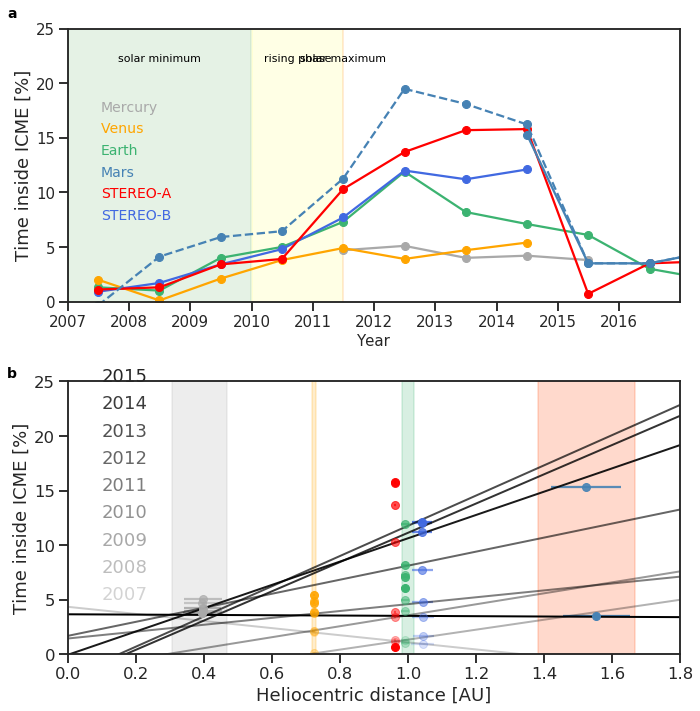

In [59]:
### maybe fix that VEX MESSENGER impact frequency is less than 1 AU by multiplying with a factor of 1.5
#check exact values with frequency plot
#inside_vex_perc=inside_vex_perc*1.5
#inside_mes_perc=inside_mes_perc*1.5

sns.set_context("talk")     
sns.set_style("ticks",{'grid.linestyle': '--'})

fig=plt.figure(5,figsize=(10,10	))

ax1 = plt.subplot(211) 

plt.plot_date(yearly_mid_times,inside_win_perc,'o',color='mediumseagreen',markersize=8, linestyle='-')
plt.plot_date(yearly_mid_times,inside_merc_perc,'o',color='darkgrey',markersize=8,linestyle='-')
plt.plot_date(yearly_mid_times,inside_vex_perc,'o',color='orange',markersize=8,linestyle='-')
plt.plot_date(yearly_mid_times,inside_stb_perc,'o',color='royalblue',markersize=8,linestyle='-')
plt.plot_date(yearly_mid_times,inside_sta_perc,'o',color='red',markersize=8,linestyle='-')
plt.plot_date(yearly_mid_times,inside_mav_perc,'o',color='steelblue',markersize=8,linestyle='-')

plt.ylabel('Time inside ICME [%]')

#plt.xlim(yearly_bin_edges[0],yearly_bin_edges[10])
ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)

#sets planet / spacecraft labels
xoff=0.15
yoff=0.85
fsize=14

plt.figtext(xoff,yoff-0.03*0,'Mercury',color='darkgrey', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*1,'Venus',color='orange', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*2,'Earth',color='mediumseagreen', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*3,'Mars',color='steelblue', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*4,'STEREO-A',color='red', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*5,'STEREO-B',color='royalblue', fontsize=fsize, ha='left')
#panel labels
plt.figtext(0.02,0.98,'a',color='black', fontsize=fsize, ha='left',fontweight='bold')
plt.figtext(0.02,0.48,'b',color='black', fontsize=fsize, ha='left',fontweight='bold')

#limits solar min/rise/max

vlevel=22
fsize=11

plt.axvspan(minstart_num,minend_num, color='green', alpha=0.1)
plt.annotate('solar minimum',xy=(minstart_num+(minend_num-minstart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
#plt.annotate('<',xy=(minstart_num+10,vlevel),ha='left', fontsize=fsize)
#plt.annotate('>',xy=(minend_num-10,vlevel),ha='right', fontsize=fsize)


plt.axvspan(risestart_num,riseend_num, color='yellow', alpha=0.1)
plt.annotate('rising phase',xy=(risestart_num+(riseend_num-risestart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
#plt.annotate('<',xy=(risestart_num+10,vlevel),ha='left', fontsize=fsize)
#plt.annotate('>',xy=(riseend_num-10,vlevel),ha='right', fontsize=fsize)

plt.axvspan(maxstart_num,maxstart_num, color='red', alpha=0.1)
plt.annotate('solar maximum',xy=(maxstart_num+(maxstart_num-maxstart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
#plt.annotate('<',xy=(maxstart_num+10,vlevel),ha='left', fontsize=fsize)
#plt.annotate('>',xy=(maxstart_num,vlevel),ha='right', fontsize=fsize)


plt.ylim((0,25))
fsize=15
plt.ylabel('Time inside ICME [%]')
plt.xlabel('Year',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 

plt.tight_layout()
#plt.ylim(0,45)
plt.xlim(yearly_start_times_d[0],yearly_end_times[9])

#sns.despine()


#### plot time inside vs. heliocentric distance

pos_wind_perc=np.zeros(np.size(yearly_mid_times))
pos_wind_perc.fill(np.nan)
pos_wind_perc_std=np.zeros(np.size(yearly_mid_times))
pos_wind_perc_std.fill(np.nan)

pos_sta_perc=np.zeros(np.size(yearly_mid_times))
pos_sta_perc.fill(np.nan)
pos_sta_perc_std=np.zeros(np.size(yearly_mid_times))
pos_sta_perc_std.fill(np.nan)

pos_stb_perc=np.zeros(np.size(yearly_mid_times))
pos_stb_perc.fill(np.nan)
pos_stb_perc_std=np.zeros(np.size(yearly_mid_times))
pos_stb_perc_std.fill(np.nan)

#pos_mes_perc=np.zeros(np.size(yearly_mid_times))
#pos_mes_perc.fill(np.nan)
#pos_mes_perc_std=np.zeros(np.size(yearly_mid_times))
#pos_mes_perc_std.fill(np.nan)


pos_merc_perc=np.zeros(np.size(yearly_mid_times))
pos_merc_perc.fill(np.nan)
pos_merc_perc_std=np.zeros(np.size(yearly_mid_times))
pos_merc_perc_std.fill(np.nan)

pos_vex_perc=np.zeros(np.size(yearly_mid_times))
pos_vex_perc.fill(np.nan)
pos_vex_perc_std=np.zeros(np.size(yearly_mid_times))
pos_vex_perc_std.fill(np.nan)

pos_mav_perc=np.zeros(np.size(yearly_mid_times))
pos_mav_perc.fill(np.nan)
pos_mav_perc_std=np.zeros(np.size(yearly_mid_times))
pos_mav_perc_std.fill(np.nan)


allpositions=np.zeros([np.size(yearly_mid_times), 6])
allinside=np.zeros([np.size(yearly_mid_times), 6])

#calculate average distance +/- std for each year
#go through each year 
for i in range(np.size(yearly_mid_times)):
  
  #select those positions that are inside the current year
  thisyear=np.where(np.logical_and((pos_time_num > yearly_start_times[i]),(pos_time_num < yearly_end_times[i])))
  
  #pos_mes_perc[i]=np.mean(pos.messenger[0][thisyear])
  #pos_mes_perc_std[i]=np.std(pos.messenger[0][thisyear])
  pos_merc_perc[i]=np.mean(pos.mercury[0][thisyear])
  pos_merc_perc_std[i]=np.std(pos.mercury[0][thisyear])
  

  pos_mav_perc[i]=np.mean(pos.mars[0][thisyear])
  pos_mav_perc_std[i]=np.std(pos.mars[0][thisyear])

  pos_vex_perc[i]=np.mean(pos.venus[0][thisyear])
  pos_vex_perc_std[i]=np.std(pos.venus[0][thisyear])

  pos_wind_perc[i]=np.mean(pos.earth_l1[0][thisyear])
  pos_wind_perc_std[i]=np.std(pos.earth_l1[0][thisyear])

  pos_sta_perc[i]=np.mean(pos.sta[0][thisyear])
  pos_sta_perc_std[i]=np.std(pos.sta[0][thisyear])

  pos_stb_perc[i]=np.mean(pos.stb[0][thisyear])
  pos_stb_perc_std[i]=np.std(pos.stb[0][thisyear])
  
  allpositions[i][:]=(pos_merc_perc[i], pos_mav_perc[i], pos_vex_perc[i],pos_wind_perc[i],pos_sta_perc[i],pos_stb_perc[i])
  allinside[i][:]=(inside_merc_perc[i], inside_mav_perc[i], inside_vex_perc[i],inside_win_perc[i],inside_sta_perc[i],inside_stb_perc[i])
  
 
  



#***make alpha variable for each year?

ax3 = plt.subplot(212) 


#for every year linear fit **check if power law works better

#for fit plotting
xfit=np.linspace(0,2,1000)

#allpositions[i] and allinside[i] are the data for each year
#no fit for 2016 as only MAVEN data is available


for i in range(np.size(yearly_mid_times)-2):
 #make linear fits ignoring NaN
 notnan=np.where(np.isfinite(allinside[i]) > 0)
 durfit=np.polyfit(allpositions[i][notnan],allinside[i][notnan],1)
 #this is similar to D=durfit[0]*xfit+durfit[1]
 durfitfun=np.poly1d(durfit)
 print('year',i+2007)
 print('time inside linear fit: D[hours]={:.2f}r[AU]+{:.2f}'.format(durfit[0],durfit[1]))
 plt.plot(xfit,durfitfun(xfit),'-',color='black', lw=2, alpha=i/10+0.2)#,label='fit')
 
 plt.errorbar(pos_merc_perc[i], inside_merc_perc[i], xerr=pos_merc_perc_std[i],yerr=0,fmt='o',color='darkgrey',markersize=8,linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_mav_perc[i], inside_mav_perc[i],xerr=pos_mav_perc_std[i],fmt='o',color='steelblue',markersize=8,linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_sta_perc[i], inside_sta_perc[i],xerr=pos_sta_perc_std[i],fmt='o',color='red',markersize=8,linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_stb_perc[i], inside_stb_perc[i],xerr=pos_stb_perc_std[i],fmt='o',color='royalblue',markersize=8,linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_wind_perc[i], inside_win_perc[i],xerr=pos_wind_perc_std[i],fmt='o',color='mediumseagreen',markersize=8, linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_vex_perc[i], inside_vex_perc[i],xerr=pos_vex_perc_std[i],fmt='o',color='orange',markersize=8,linestyle=' ',alpha=i/10+0.2)
 
 plt.annotate(str(i+2007), xy=(0.1,5+2.5*i), alpha=i/10+0.2)
 
 
 #reconstruct Mars time inside from linear fits but not for years 2015 /2016
 if i < 8: inside_mav_perc[i]=durfitfun(pos_mav_perc[i])


#mars limits
plt.axvspan(np.min(pos.mars[0]),np.max(pos.mars[0]), color='orangered', alpha=0.2)
#plt.figtext(0.8,0.8,'Mars',color='orangered')
plt.axvspan(np.min(pos.mercury[0]),np.max(pos.mercury[0]), color='darkgrey', alpha=0.2)
#plt.figtext(0.25,0.8,'Mercury',color='darkgrey')
plt.axvspan(np.min(pos.venus[0]),np.max(pos.venus[0]), color='orange', alpha=0.2)
#plt.figtext(0.42,0.8,'Venus',color='orange')
plt.axvspan(np.min(pos.earth[0]),np.max(pos.earth[0]), color='mediumseagreen', alpha=0.2)
#plt.figtext(0.6,0.8,'Earth',color='mediumseagreen')
plt.xlim(0,1.8)

#solar probe plus 10 to 36 Rs close approaches

#plt.axvspan(Rs_in_AU*10,Rs_in_AU*36,color='magenta', alpha=0.2)

plt.ylabel('Time inside ICME [%]')
plt.xlabel('Heliocentric distance [AU]')
ax3.set_xticks(np.arange(0,2,0.2))

#add reconstructed Mars time inside on previous plot
ax1.plot_date(yearly_mid_times,inside_mav_perc,'o',color='steelblue',markersize=8,linestyle='--')


plt.ylim((0,25))

plt.tight_layout()

plt.savefig('results/plots_stats/time_inside_CMEs_paper.pdf', dpi=300)
plt.savefig('results/plots_stats/time_inside_CMEs_paper.png', dpi=300)





#TI

print()
print()
print('--------------------------------------------------')
print()
print()

print('Time Inside')

print()
print('Mercury +/-')
print(round(np.nanmean(inside_merc_cycle),1))
print(round(np.nanstd(inside_merc_cycle),1))
#print('min')
#print(round(inside_merc_cycle[0],1))
print('rise')
print(round(inside_merc_cycle[1],1))
print('max')
print(round(inside_merc_cycle[2],1))


print()
print('Venus +/-')
print(round(np.nanmean(inside_vex_cycle),1))
print(round(np.nanstd(inside_vex_cycle),1))
print('min')
print(round(inside_vex_cycle[0],1))
print('rise')
print(round(inside_vex_cycle[1],1))
print('max')
print(round(inside_vex_cycle[2],1))


print()
print('Earth +/-')
print(round(np.nanmean(inside_win_cycle),1))
print(round(np.nanstd(inside_win_cycle),1))
print('min')
print(round(inside_win_cycle[0],1))
print('rise')
print(round(inside_win_cycle[1],1))
print('max')
print(round(inside_win_cycle[2],1))


#only declining phase
print('MAVEN')
print(round(inside_mav_cycle[1],1))




###################### MAVEN

#from processing program
#all in days
totaldays=385 
total_icme_duration_maven=np.sum(ic.icme_duration[mavi])/24

print()
print()
print()


print('MAVEN results from 385 days of data, Dec 2014-Feb 2016, with gaps where no solar wind is available')
print('MAVEN total days of observations with solar wind data:')
print(totaldays)
print('MAVEN total ICME durations:')
print(total_icme_duration_maven)
print('Mars is in percent of time inside ICMEs, for intervals in 2014-2016 (declining phase):')
print(total_icme_duration_maven/totaldays*100)
print('on average, Mars is hit by a CME every ... days')
print(totaldays/np.size(mavi))
print('The ICME average duration is, in hours')
print(np.mean(ic.icme_duration[mavi]))